In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import math
from sklearn.preprocessing import MinMaxScaler
import pywt
from scipy.signal import medfilt

In [2]:
def denoise(data):
    #小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [3]:
ours = pd.read_excel("./dataset/ecg400hz_0425.xlsx", header=None)
ours = ours.iloc[1:, 0:15]
ours = ours.T

In [4]:
# normalization
def norm(X):
    for i in range(X.shape[0]):
        row = X[i, :]
        X[i, :] = (row - row.min())/(row.max()-row.min())
    return

In [5]:
def downsample(signal):
    downsample_signal = []
    signal_array = signal.to_numpy()
    
    for i in range(0,len(signal_array),2):
        downsample_signal.append(signal_array[i])
    
    return downsample_signal

In [6]:
from scipy import signal

def read_our_data(data):
    our_data = []
        
    for i in range(data.shape[0]):
        s = data.iloc[i, :]
        s = s.dropna()
        
        down_signal = downsample(s)             # downsampling to 200 Hz
        ecg_signal = down_signal[500:]          # drop 500 unstable data

        # median filter
        filt = int(190*0.8)
        Filter = medfilt(ecg_signal, filt+1)
        signal_filt = ecg_signal - Filter

#         signal_denoise = signal_filt
        
        # wavelet transform
        signal_denoise = denoise(signal_filt)
        
#         print(f'signal_denoise len = {len(signal_denoise)}')
        # splicing data into 370
        for i in range(0,len(signal_denoise), 370):
            if i + 370 >= len(signal_denoise):
                break
            tmp = signal_denoise[i:i+370]
            our_data.append(tmp)

            
    our_data = np.array(our_data)

    return our_data

<h2> Read our data and merged into normal dataset

In [7]:
our_data = read_our_data(ours)

D:\anaconda\envs\tensorflow\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [9]:
covid = pd.read_csv('./dataset/Covid_lead I.csv', header=None)
normal = pd.read_csv('./dataset/Normal_lead I.csv', header=None)
covid = np.array(covid.T)
normal = np.array(normal.T)

In [10]:
from sklearn.model_selection import train_test_split
normal_dataset_train, normal_dataset_test = train_test_split(normal, train_size=0.8, shuffle=True)
our_data_train, our_data_test = train_test_split(our_data, train_size=0.1, shuffle=True)

<h2> Split COVID and NORMAL data for training data & test data

In [11]:
normal_X_train = np.concatenate((normal_dataset_train, our_data_train))
normal_X_test = np.concatenate((normal_dataset_test, our_data_test))
covid_X_train, covid_X_test = train_test_split(covid, train_size=0.8, shuffle=True)

In [13]:
norm(normal_X_train)
norm(normal_X_test)
norm(covid_X_train)
norm(covid_X_test)

In [14]:
for i in range(200):
    noise = 0.05 * np.random.normal(0, 0.1, 370);
    noisySignal = covid_X_train[i] + noise;
    covid_X_train = np.vstack([covid_X_train, noisySignal])
    
    noise2 = 0.05 * np.random.normal(0, 0.2, 370);
    noisySignal2 = covid_X_train[i] + noise2;
    covid_X_train = np.vstack([covid_X_train, noisySignal2])
    
    noise3 = 0.05 * np.random.normal(0, 0.3, 370);
    noisySignal3 = covid_X_train[i] + noise3;
    covid_X_train = np.vstack([covid_X_train, noisySignal3])

In [15]:
normal_Y_train = np.zeros(len(normal_X_train))
normal_Y_test = np.zeros(len(normal_X_test))
covid_Y_train = np.ones(len(covid_X_train))
covid_Y_test = np.ones(len(covid_X_test))

In [16]:
X_train = np.concatenate((normal_X_train, covid_X_train))
Y_train = np.concatenate((normal_Y_train, covid_Y_train))
X_test = np.concatenate((normal_X_test, covid_X_test))
Y_test = np.concatenate((normal_Y_test, covid_Y_test))

<h2> make X_data type to 0 ~ 255

In [18]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = min(255, int(X_train[i][j]*255))
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = min(255, int(X_test[i][j]*255))       

<h2> Get testsamples on board ( 0~ 255 without minus 128 ).

In [19]:
X_test_board = np.concatenate((X_test[0:25], X_test[6673:6673+25]))
Y_test_board = np.concatenate((np.zeros(25), np.ones(25)))

<h2> make data to -128 ~ 127

In [20]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        X_train[i][j] = X_train[i][j] - 128
        
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        X_test[i][j] = X_test[i][j] - 128

<h2> Suffle

In [21]:
import random
def shuffle_array(X, Y):
    shuffle_index= np.arange(X.shape[0])
    random.shuffle(shuffle_index)
    shuffle_X = X[shuffle_index]
    shuffle_Y = Y[shuffle_index]
    return shuffle_X, shuffle_Y

In [22]:
X_train, Y_train = shuffle_array(X_train, Y_train)
X_test = np.concatenate((X_test[0:100], X_test[6673:6673+50]))
Y_test = np.concatenate((Y_test[0:100], Y_test[6673:6673+50]))

In [25]:
from keras.utils.np_utils import *
Y_train = to_categorical(Y_train, 2)
Y_test = to_categorical(Y_test, 2)
print(Y_train.shape, Y_test.shape)

(1697, 2) (150, 2)


<h2> CNN model

In [26]:
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1],1,1)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1],1,1)

In [27]:
X_test_reshaped.shape, X_train_reshaped.shape

((150, 370, 1, 1), (1697, 370, 1, 1))

In [28]:
# X_test_reshaped = X_test_reshaped.astype(np.uint8)
# X_train_reshaped = X_train_reshaped.astype(np.uint8)

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint


keras.backend.clear_session()

def build_model():
    model = Sequential()
    model.add(Conv2D(filters=24, kernel_size=(3,1), padding='same', activation='relu', input_shape=(370, 1,1)))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=24, kernel_size=(3,1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,1)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(24, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 370, 1, 24)        96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 1, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 123, 1, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 1, 24)        1752      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 1, 24)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 1, 24)         0         
_________________________________________________________________
flatten (Flatten)            (None, 984)               0

In [31]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_function = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.000000001)
callbacks_list = [learning_rate_function]
history = model.fit(X_train_reshaped, Y_train, epochs=70, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/70
43/43 [==============================] - 3s 77ms/step - loss: 1.8406 - accuracy: 0.5718 - val_loss: 0.7495 - val_accuracy: 0.5824
Epoch 2/70
43/43 [==============================] - 2s 37ms/step - loss: 0.6749 - accuracy: 0.6345 - val_loss: 0.6286 - val_accuracy: 0.6412
Epoch 3/70
43/43 [==============================] - 1s 27ms/step - loss: 0.5777 - accuracy: 0.6912 - val_loss: 0.5845 - val_accuracy: 0.6824
Epoch 4/70
43/43 [==============================] - 1s 25ms/step - loss: 0.4784 - accuracy: 0.7723 - val_loss: 0.4057 - val_accuracy: 0.8647
Epoch 5/70
43/43 [==============================] - 1s 29ms/step - loss: 0.3613 - accuracy: 0.8371 - val_loss: 0.3611 - val_accuracy: 0.8941
Epoch 6/70
43/43 [==============================] - 1s 17ms/step - loss: 0.2129 - accuracy: 0.9197 - val_loss: 0.2052 - val_accuracy: 0.9471
Epoch 7/70
43/43 [==============================] - 1s 18ms/step - loss: 0.1663 - accuracy: 0.9359 - val_loss: 0.1935 - val_accuracy: 0.9735
Epoch 8/70
43

Epoch 53/70
43/43 [==============================] - 1s 17ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0909 - val_accuracy: 0.9824
Epoch 54/70
43/43 [==============================] - 1s 18ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0906 - val_accuracy: 0.9824
Epoch 55/70
43/43 [==============================] - 1s 18ms/step - loss: 0.0030 - accuracy: 0.9985 - val_loss: 0.0905 - val_accuracy: 0.9824
Epoch 56/70
43/43 [==============================] - 1s 18ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0914 - val_accuracy: 0.9824
Epoch 57/70
41/43 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 0.9992
Epoch 00057: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
43/43 [==============================] - 1s 17ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0898 - val_accuracy: 0.9824
Epoch 58/70
43/43 [==============================] - 1s 18ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0902 - val_ac

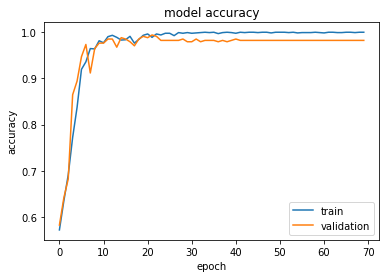

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

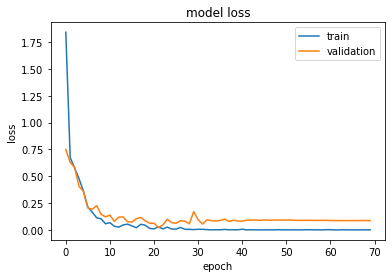

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [34]:
keras.backend.clear_session()
model2 = model
[loss, acc] = model2.evaluate(X_test_reshaped, Y_test, verbose=1)

5/5 [==============================] - 0s 4ms/step - loss: 0.4446 - accuracy: 0.9600


In [35]:
prediction = model2.predict(X_test_reshaped)
classes = np.argmax(prediction, axis=1)
classes

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [36]:
X_test_reshaped.shape

(150, 370, 1, 1)

In [37]:
ans = [int(i) for i in Y_test[:, 1]]

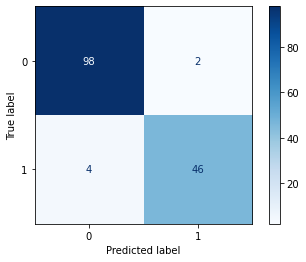

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(ans, classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

<h1> converted to tflite

In [39]:
model2.save('model_save')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_save\assets


In [40]:
model_test = keras.models.load_model('model_save')

# Model Evaluation
score = model_test.evaluate(X_test_reshaped, Y_test, verbose = 0)
print('test loss', score[0])
print('accuracy', score[1])

test loss 0.4446101784706116
accuracy 0.9599999785423279


## Quantization

In [41]:
model = model_test

In [42]:
# tensorflow lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmp824wybgz\assets


In [43]:
train_data = tf.cast(X_test_reshaped, tf.float32)
# train_data = X_train_reshaped
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_data).batch(1).take(100):
    # Model has only one input so each data point has one element.
        yield [input_value]

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_data_gen

tflite_model_quant_int8 = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpt9rf4ztn\assets


INFO:tensorflow:Assets written to: C:\Users\陳奕帆\AppData\Local\Temp\tmpt9rf4ztn\assets


In [45]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>


In [46]:
import pathlib

tflite_models_dir = pathlib.Path("generated/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file_int8 = tflite_models_dir/"tflite_model_quant_int8.tflite"
tflite_model_quant_file_int8.write_bytes(tflite_model_quant_int8)

31360

## Evaluate TensorFlow Lite Quant (int8) Model

In [47]:
def evaluate_model(interpreter, X_test, Y_test):
#     X_test_data = tf.cast(X_test, tf.float32)

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    scale, zero_point = interpreter.get_input_details()[0]['quantization']

    prediction_values = []
    
    i=0
    for test_data in X_test:
#         print('Processing '+str(i)+' data');
        # Pre-processing: add batch dimension, quantize and convert inputs to int8 to match with
        # the model's input data format.
        test_data = np.expand_dims(test_data, axis=0)#.astype(interpreter.get_input_details()[0]["dtype"])
        test_data = np.int8(test_data / scale + zero_point)
        interpreter.set_tensor(input_index, test_data)

        interpreter.invoke()

        # Find the letter with highest probability
        output = interpreter.tensor(output_index)
#         print(output())
        result = np.argmax(output()[0])
        prediction_values.append(result)
        i = i + 1
    
    print(prediction_values)
    accurate_count = 0
    for index in range(len(prediction_values)):
        if prediction_values[index] == Y_test[index]:
            accurate_count += 1
    accuracy = accurate_count * 1.0 / len(prediction_values)

    return accuracy * 100

In [48]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file_int8))
interpreter.allocate_tensors()

print(str(evaluate_model(interpreter, X_test_reshaped, Y_test[:,1])) + "%")

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
96.0%


<h2> Transfer test data to Cpp

In [49]:
X_test_board.shape, Y_test_board.shape

((50, 370), (50,))

In [50]:
samples_file = open("generated/test_samples_c.cpp", "w")

samples_file.write("#include \"test_samples.h\"\n\n")
samples_file.write("const int kNumSamples = " + str(48) + ";\n\n")

samples = "" 
samples_array = "const TestSample_c test_samples_c[kNumSamples] = {"

for index in range(48):
    data_arr = list(np.ndarray.flatten(X_test_board[index]))
    data_arr = [int(i) for i in data_arr]
    var_name = "sample" + str(index+1) + "c"
    samples += "TestSample_c " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
    samples += "\t.label = " + str(int(Y_test_board[index])) + ",\n" 
    samples += "\t.image = {\n"
    wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
    for sub_arr in wrapped_arr:
        samples += "\t\t" + str(sub_arr)
    samples += "\t}\n};\n\n"    
    samples_array += var_name + ", "
    
samples = samples.replace("[", "")
samples = samples.replace("]", ",\n")
samples_array += "};\n"

samples_file.write(samples);
samples_file.write(samples_array);
samples_file.close()

In [51]:
samples_file = open("generated/test_samples_2.cpp", "w")

samples_file.write("#include \"test_samples.h\"\n\n")
samples_file.write("const int kNumSamples = " + str(X_test_reshaped.shape[0]) + ";\n\n")

samples = "" 
samples_array = "const TestSample_c test_samples_c[kNumSamples] = {"

for index in range(X_test_reshaped.shape[0]):
    data_arr = list(np.ndarray.flatten(X_test_reshaped[index]))
    data_arr = [int(i) for i in data_arr]
    var_name = "sample" + str(index+1)
    samples += "TestSample_c " + var_name + " = {\n" #+ "[IMAGE_SIZE] = { "
    samples += "\t.label = " + str(int(Y_test[index,1])) + ",\n" 
    samples += "\t.image = {\n"
    wrapped_arr = [data_arr[i:i + 10] for i in range(0, len(data_arr), 10)]
    for sub_arr in wrapped_arr:
        samples += "\t\t" + str(sub_arr)
    samples += "\t}\n};\n\n"    
    samples_array += var_name + ", "
    
samples = samples.replace("[", "")
samples = samples.replace("]", ",\n")
samples_array += "};\n"

samples_file.write(samples);
samples_file.write(samples_array);
samples_file.close()